In [2]:
import os, sys, glob, shutil, json
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import cv2
from PIL import Image
import numpy as np
from tqdm import tqdm, tqdm_notebook
import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset


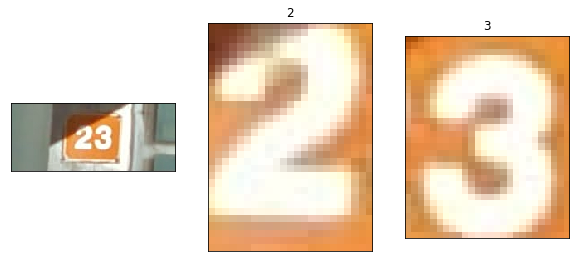

In [14]:
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
train_json = json.load(open('../input/train.json'))

# 数据标注处理
def parse_json(d):
    arr = np.array([
        d['top'], d['height'], d['left'], d['width'], d['label']
    ])
    arr = arr.astype(int)
    return arr
img = cv2.imread('../input/train/000001.png')
arr = parse_json(train_json['000001.png'])

plt.figure(figsize=(10, 10))
plt.subplot(1, arr.shape[1]+1, 1)
plt.imshow(img)
plt.xticks([]); plt.yticks([])
for idx in range(arr.shape[1]):
    plt.subplot(1, arr.shape[1]+1, idx+2)
    plt.imshow(img[arr[0, idx]:arr[0, idx]+arr[1, idx],arr[2, idx]:arr[2, idx]+arr[3, idx]])
    plt.title(arr[4, idx])
    plt.xticks([]); plt.yticks([])

In [3]:
# 定义读取图像的Dataset
class SVHNDataset(Dataset):
    def __init__(self, img_path, img_label, transform=None):
        self.img_path = img_path
        self.img_label = img_label
        if transform is not None:
            self.transform = transform
        else:
            self.transform = None
    def __getitem__(self, index):  #索引的时候，会自动调用__getitem__方法，然后单张的读取图片。
        img = Image.open(self.img_path[index]).convert('RGB')
        
        if self.transform is not None:
            img = self.transform(img)
            
        # 设置最长的字符长度为5个,超过5个只取前5个，不足5个用字符10补齐
        lbl = np.array(self.img_label[index],dtype = np.int)
        lbl = list(lbl)+(5-len(lbl))*[10]
        return img, torch.from_numpy(np.array(lbl[:5]))
    
    def __len__(self):
        return len(self.img_path)

In [4]:
# 定义好训练数据和验证数据的Dataset
train_path = glob.glob('../input/train/*.png') #glob相当于os遍历文件夹下的png文件
train_path.sort()
# train_json = json.load('../input/train.json')
with open('../input/train.json') as f:
    train_json = json.load(f)
train_label = [train_json[x]['label'] for x in train_json]
print(len(train_path),len(train_label))

train_loader = torch.utils.data.DataLoader(
    SVHNDataset(train_path, train_label,
                transforms.Compose([
                    transforms.Resize((64, 128)), #缩放到固定尺寸
                    transforms.RandomCrop((60, 120)),    #随机剪裁
                    transforms.ColorJitter(0.3, 0.3, 0.2), #随机颜色变换
                    transforms.RandomRotation(10), #加入随机旋转
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])), 
    batch_size=40, 
    shuffle=True, 
    num_workers=0,
)

30000 30000


In [5]:
val_path = glob.glob('../input/val/*.png')
val_path.sort()
# val_json = json.load(open('../input/val.json'))
with open('../input/val.json') as f:
    val_json = json.load(f)
val_label = [val_json[x]['label'] for x in val_json]
print(len(val_path), len(val_label))

val_loader = torch.utils.data.DataLoader(
    SVHNDataset(val_path, val_label,
                transforms.Compose([
                    transforms.Resize((60, 120)),
                    # transforms.ColorJitter(0.3, 0.3, 0.2),
                    # transforms.RandomRotation(5),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])), 
    batch_size=40, 
    shuffle=False, 
    num_workers=0,
)

10000 10000


In [6]:
# 定义分类模型  ResNet18
class SVHN_Model1(nn.Module):
    def __init__(self):
        super(SVHN_Model1,self).__init__()
        
        model_conv = models.resnet18(pretrained=True)
        model_conv.avgpool = nn.AdaptiveAvgPool2d(1)
        model_conv = nn.Sequential(*list(model_conv.children())[:-1]) #去除最后一个fc layer
        self.cnn = model_conv
        
        self.fc1 = nn.Linear(512,11)
        self.fc2 = nn.Linear(512, 11)
        self.fc3 = nn.Linear(512, 11)
        self.fc4 = nn.Linear(512, 11)
        self.fc5 = nn.Linear(512, 11)
    def forward(self, img):
        feat = self.cnn(img)
#         print(feat.shape)
        feat = feat.view(feat.shape[0],-1)
        c1 = self.fc1(feat)
        c2 = self.fc2(feat)
        c3 = self.fc3(feat)
        c4 = self.fc4(feat)
        c5 = self.fc5(feat)
        return c1,c2,c3,c4,c5

In [7]:
def train(train_loader, model, criterion, optimizer, epoch):
    # 切换模型为训练模式
    model.train()
    train_loss = []
    
    for i, (input, target) in enumerate(train_loader):
        if use_cuda:
            input = input.cuda()
            target = target.cuda()
            
        c0, c1, c2, c3, c4 = model(input)
        loss = criterion(c0, target[:, 0].long()) + criterion(c1, target[:, 1].long()) + \
                criterion(c2, target[:, 2].long()) + criterion(c3, target[:, 3].long()) + \
                criterion(c4, target[:, 4].long())
        
        # loss /= 6
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())
    return np.mean(train_loss)

def validate(val_loader, model, criterion):
    # 切换模型为预测模型
    model.eval()
    val_loss = []

    # 不记录模型梯度信息
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            if use_cuda:
                input = input.cuda()
                target = target.cuda()
            
            c0, c1, c2, c3, c4 = model(input)
            loss = criterion(c0, target[:, 0].long()) + \
                    criterion(c1, target[:, 1].long()) + \
                    criterion(c2, target[:, 2].long()) + \
                    criterion(c3, target[:, 3].long()) + \
                    criterion(c4, target[:, 4].long())
            # loss /= 6
            val_loss.append(loss.item())
    return np.mean(val_loss)

def predict(test_loader, model, tta=10):
    model.eval()
    test_pred_tta = None
    
    # TTA 次数
    for _ in range(tta):
        test_pred = []
    
        with torch.no_grad():
            for i, (input, target) in enumerate(test_loader):
                if use_cuda:
                    input = input.cuda()
                
                c0, c1, c2, c3, c4 = model(input)
                if use_cuda:
                    output = np.concatenate([
                        c0.data.cpu().numpy(), 
                        c1.data.cpu().numpy(),
                        c2.data.cpu().numpy(), 
                        c3.data.cpu().numpy(),
                        c4.data.cpu().numpy()], axis=1)
                else:
                    output = np.concatenate([
                        c0.data.numpy(), 
                        c1.data.numpy(),
                        c2.data.numpy(), 
                        c3.data.numpy(),
                        c4.data.numpy()], axis=1)
                
                test_pred.append(output)
        
        test_pred = np.vstack(test_pred)
        if test_pred_tta is None:
            test_pred_tta = test_pred
        else:
            test_pred_tta += test_pred
    
    return test_pred_tta

In [11]:
model = SVHN_Model1()
criterion = nn.CrossEntropyLoss()
best_loss = 1000.0

# 是否使用GPU
use_cuda = True
if use_cuda:
    model = model.cuda()

for epoch in range(20):
    if epoch<10:
        optimizer = torch.optim.Adam(model.parameters(), 0.001)
    else:
        optimizer = torch.optim.Adam(model.parameters(),0.0001)
    train_loss = train(train_loader, model, criterion, optimizer, epoch)
    val_loss = validate(val_loader, model, criterion)
    
    val_label = [''.join(map(str, x)) for x in val_loader.dataset.img_label]
    val_predict_label = predict(val_loader, model, 1)
    val_predict_label = np.vstack([
        val_predict_label[:, :11].argmax(1),
        val_predict_label[:, 11:22].argmax(1),
        val_predict_label[:, 22:33].argmax(1),
        val_predict_label[:, 33:44].argmax(1),
        val_predict_label[:, 44:55].argmax(1),
    ]).T
    val_label_pred = []
    for x in val_predict_label:
        val_label_pred.append(''.join(map(str, x[x!=10])))
    
    val_char_acc = np.mean(np.array(val_label_pred) == np.array(val_label))
    
    print('Epoch: {0}, Train loss: {1} \t Val loss: {2}'.format(epoch, train_loss, val_loss))
    print('Val Acc', val_char_acc)
    # 记录下验证集精度
    if val_loss < best_loss:
        best_loss = val_loss
        # print('Find better model in Epoch {0}, saving model.'.format(epoch))
        torch.save(model.state_dict(), './model.pt')

Epoch: 0, Train loss: 3.6663593196868898 	 Val loss: 3.4419474391937257
Val Acc 0.3463
Epoch: 1, Train loss: 2.3542065817515057 	 Val loss: 2.98764915561676
Val Acc 0.4247
Epoch: 2, Train loss: 1.9631940975189208 	 Val loss: 2.876545383453369
Val Acc 0.4614
Epoch: 3, Train loss: 1.7285771380265553 	 Val loss: 2.8382968554496766
Val Acc 0.4854
Epoch: 4, Train loss: 1.5716067015329998 	 Val loss: 2.8798054842948915
Val Acc 0.4813
Epoch: 5, Train loss: 1.4408897026379903 	 Val loss: 2.5425176684856416
Val Acc 0.5209
Epoch: 6, Train loss: 1.3521415468056996 	 Val loss: 2.5747855396270753
Val Acc 0.5282
Epoch: 7, Train loss: 1.2600252989530563 	 Val loss: 2.4645020978450773
Val Acc 0.5402
Epoch: 8, Train loss: 1.1919125939210256 	 Val loss: 2.5220783369541167
Val Acc 0.5422
Epoch: 9, Train loss: 1.1224020988543828 	 Val loss: 2.543198872566223
Val Acc 0.5408
Epoch: 10, Train loss: 0.792724053601424 	 Val loss: 2.30143823158741
Val Acc 0.5942
Epoch: 11, Train loss: 0.7034239060084025 	 Val l

In [12]:
# 预测
test_path = glob.glob('../input/test_a/*.png')
test_path.sort()
# test_json = json.load(open('../input/test_a.json'))
test_label = [[1]] * len(test_path)
print(len(test_path), len(test_label))

test_loader = torch.utils.data.DataLoader(
    SVHNDataset(test_path, test_label,
                transforms.Compose([
                    transforms.Resize((60, 120)),
                    # transforms.RandomCrop((60, 120)),
                    # transforms.ColorJitter(0.3, 0.3, 0.2),
                    # transforms.RandomRotation(5),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])), 
    batch_size=40, 
    shuffle=False, 
    num_workers=0,
)

40000 40000


In [13]:
# 加载保存的最优模型
model.load_state_dict(torch.load('model.pt'))

test_predict_label = predict(test_loader, model, 1)
print(test_predict_label.shape)

test_label = [''.join(map(str, x)) for x in test_loader.dataset.img_label]
test_predict_label = np.vstack([
    test_predict_label[:, :11].argmax(1),
    test_predict_label[:, 11:22].argmax(1),
    test_predict_label[:, 22:33].argmax(1),
    test_predict_label[:, 33:44].argmax(1),
    test_predict_label[:, 44:55].argmax(1),
]).T

test_label_pred = []
for x in test_predict_label:
    test_label_pred.append(''.join(map(str, x[x!=10])))
    
import pandas as pd
df_submit = pd.read_csv('../input/test_A_sample_submit_A.csv')
df_submit['file_code'] = test_label_pred
df_submit.to_csv('submit.csv', index=None)

(40000, 55)
